In [1]:
import torch, torchvision
from torch import nn
from torchvision import transforms, models, datasets
import shap
import json
import numpy as np
import glob
import cv2 as cv
import pandas as pd
from PIL import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [3]:
images = glob.glob('/home/vislab/dolearn-jimin-41/data/image_plt/*.png')
label=pd.read_csv('/home/vislab/dolearn-jimin-41/data/y_data_label.csv')
print(len(images))

332


In [4]:
mel_images=[]
mel_labels=[]
i=0
for fname in images:
    #if i % 10 == 0 :
    image_pil = Image.open(fname).convert('L')
    image_bw = np.array(image_pil)
    mel_images.append(image_bw)
    mel_labels.append(label['0'][i])
    i+=1

mel_images=np.array(mel_images)

In [5]:
len(mel_images)

332

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


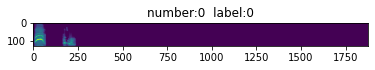

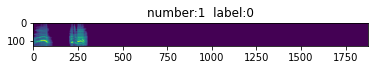

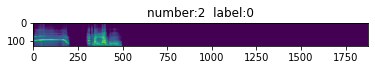

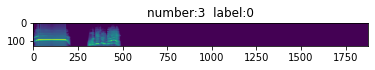

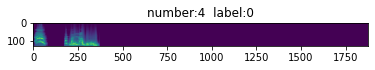

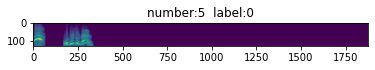

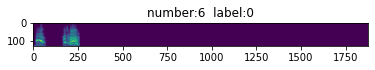

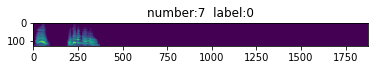

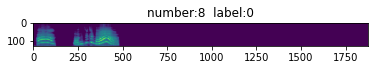

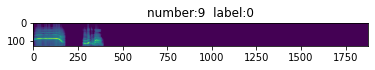

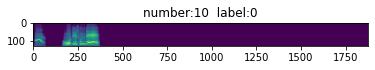

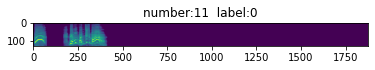

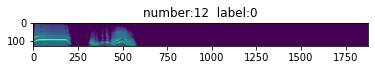

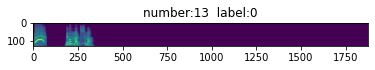

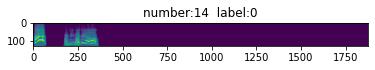

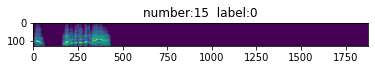

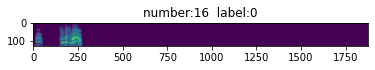

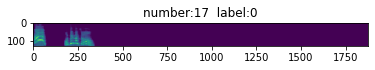

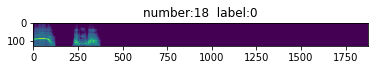

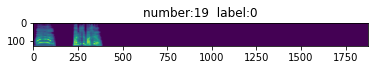

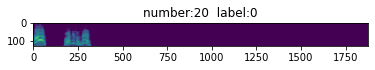

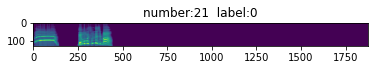

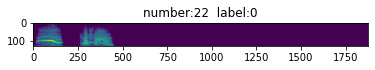

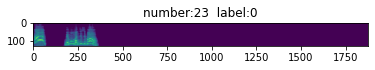

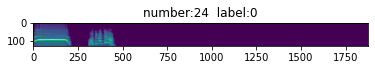

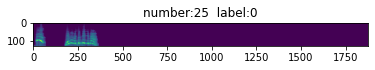

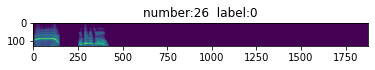

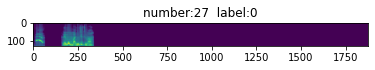

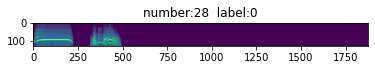

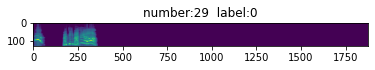

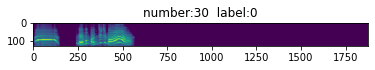

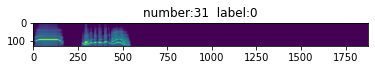

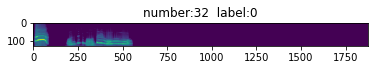

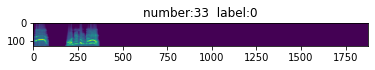

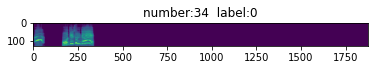

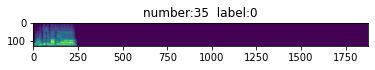

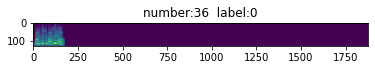

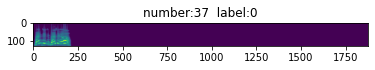

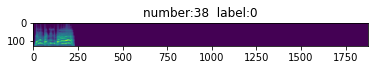

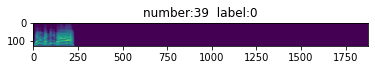

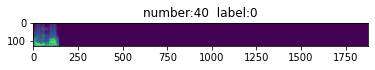

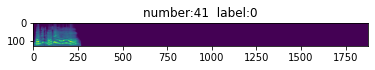

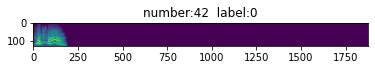

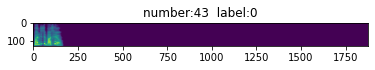

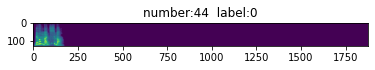

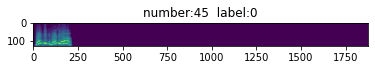

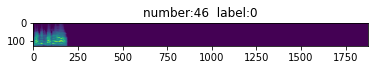

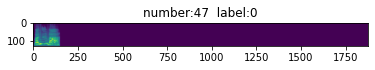

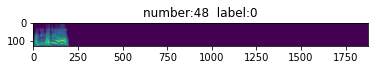

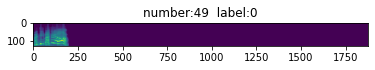

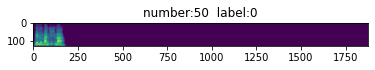

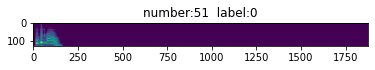

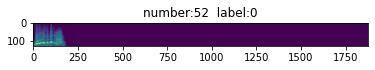

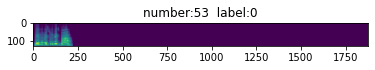

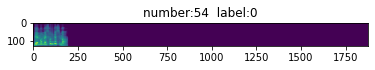

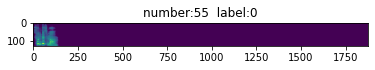

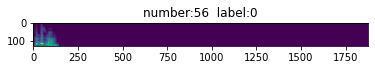

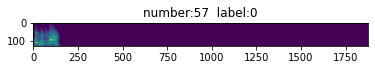

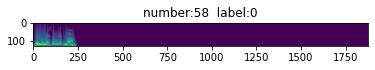

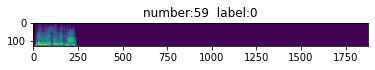

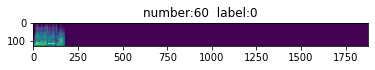

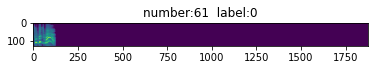

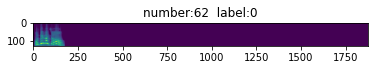

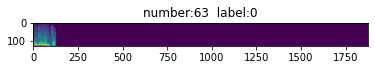

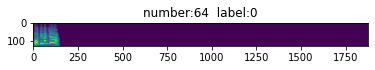

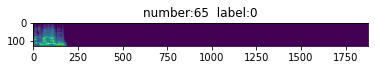

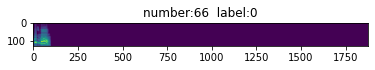

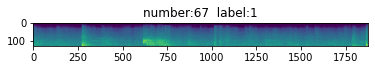

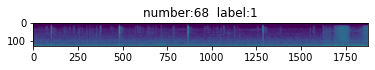

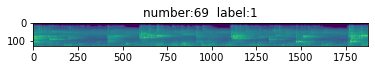

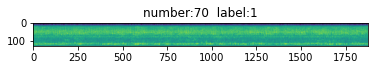

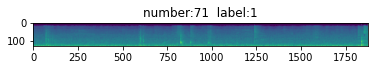

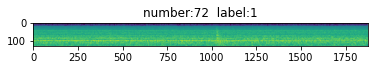

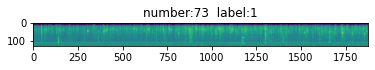

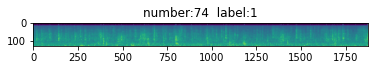

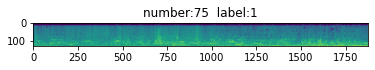

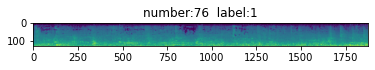

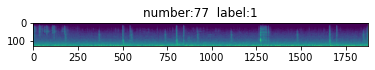

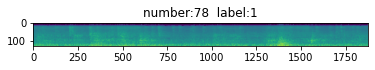

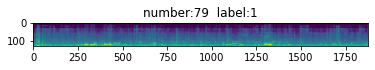

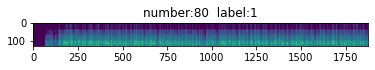

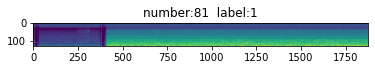

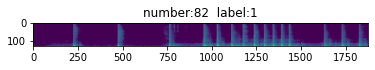

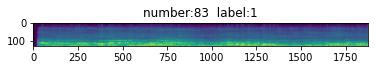

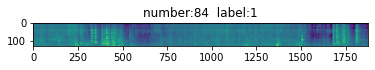

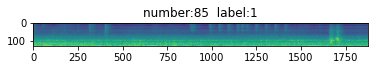

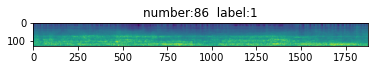

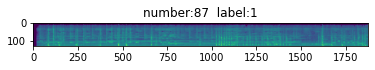

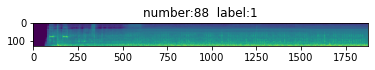

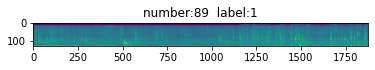

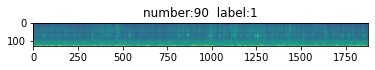

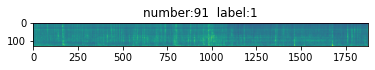

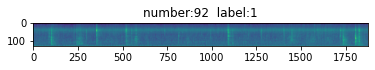

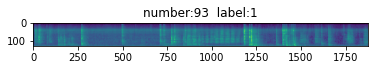

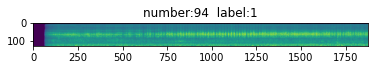

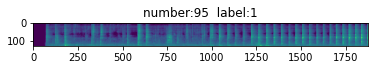

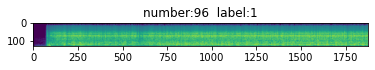

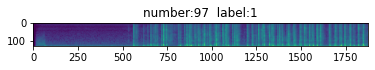

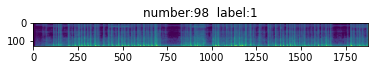

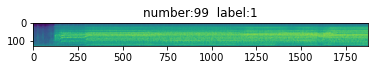

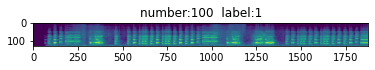

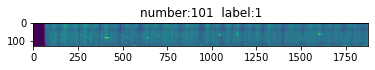

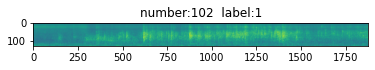

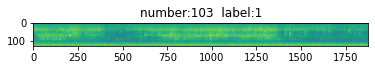

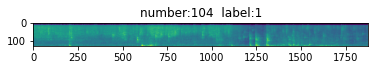

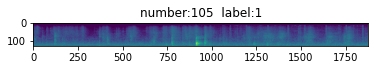

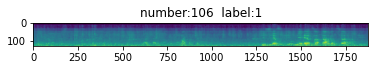

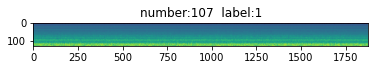

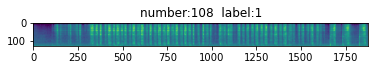

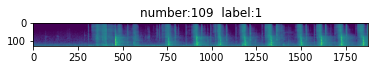

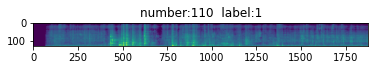

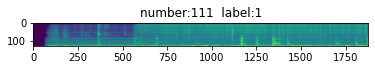

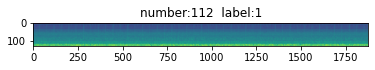

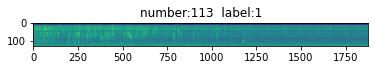

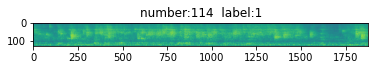

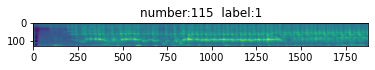

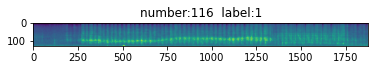

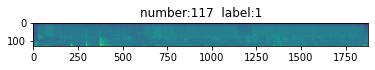

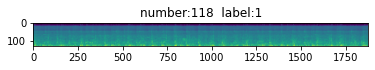

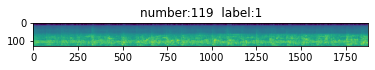

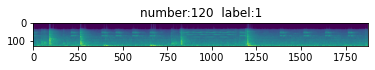

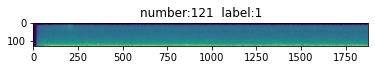

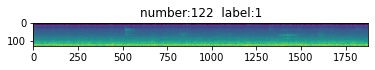

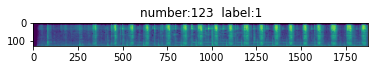

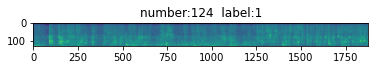

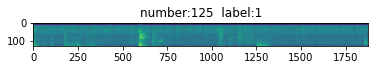

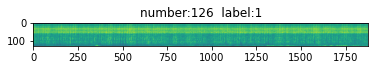

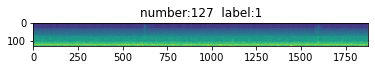

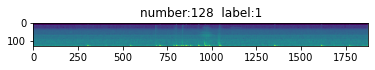

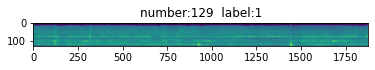

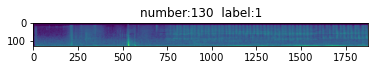

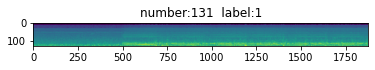

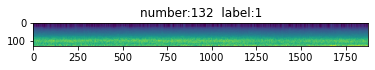

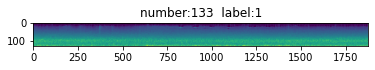

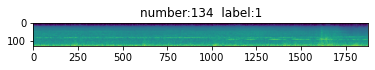

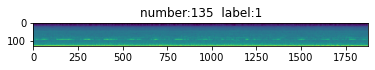

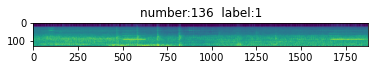

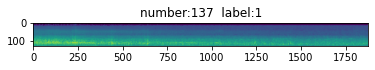

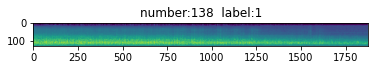

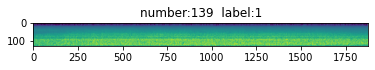

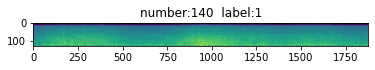

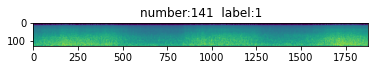

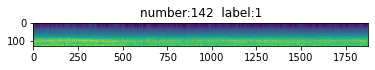

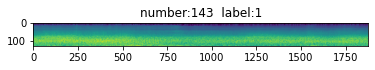

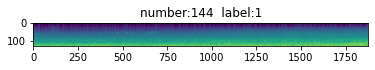

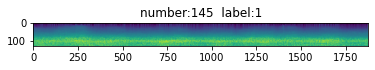

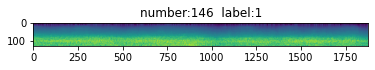

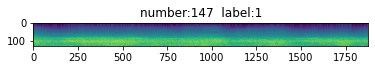

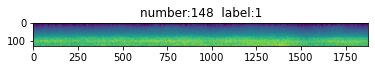

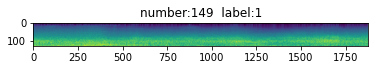

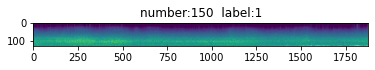

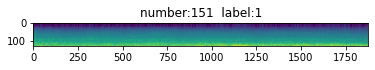

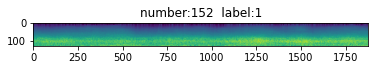

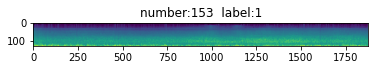

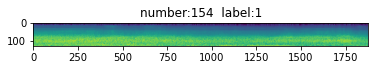

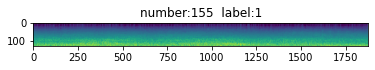

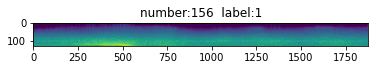

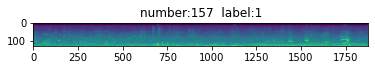

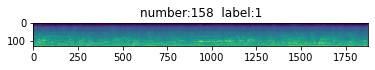

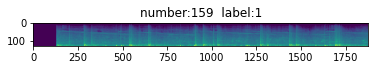

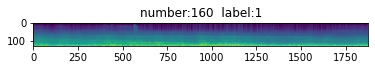

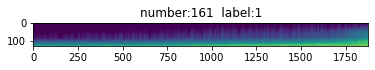

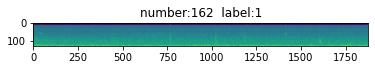

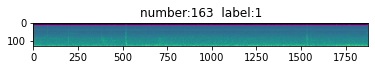

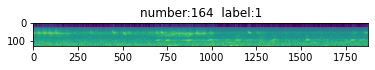

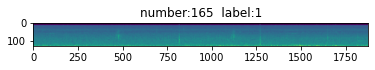

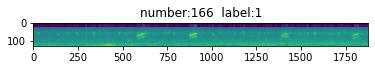

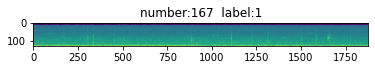

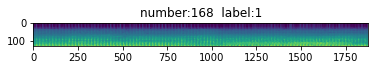

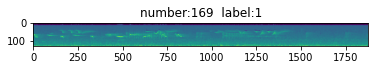

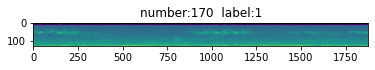

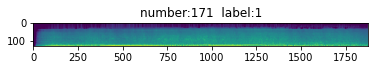

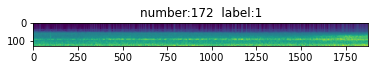

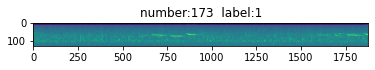

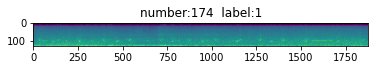

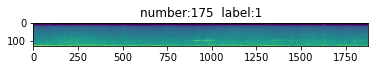

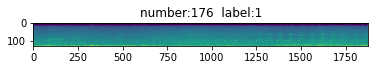

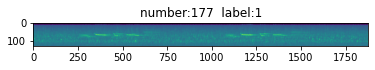

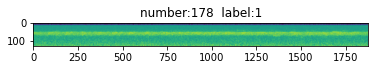

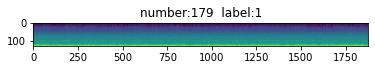

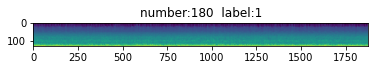

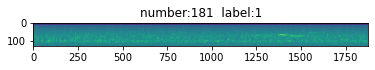

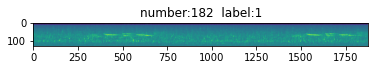

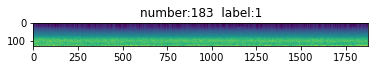

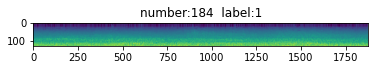

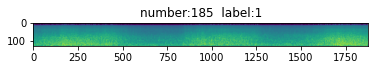

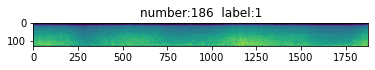

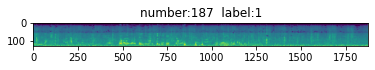

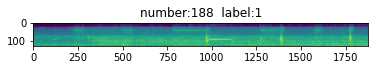

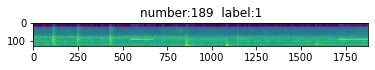

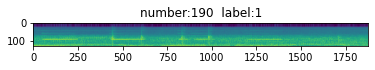

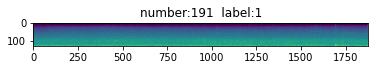

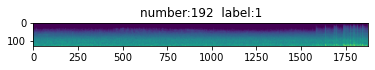

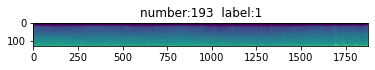

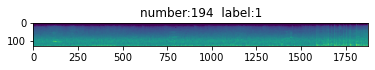

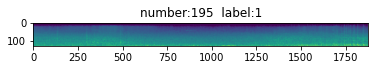

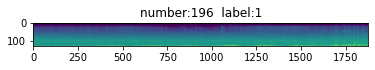

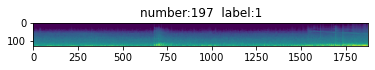

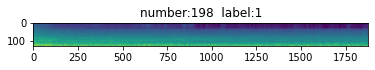

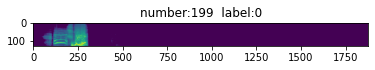

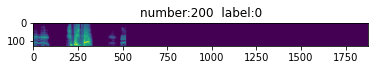

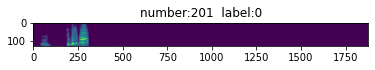

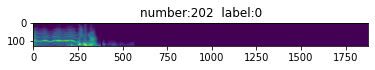

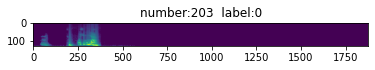

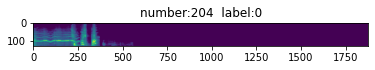

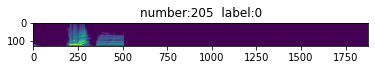

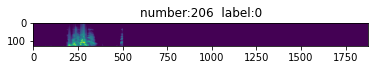

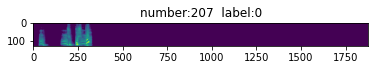

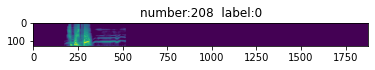

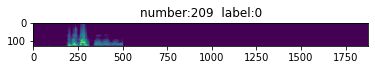

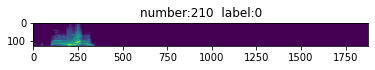

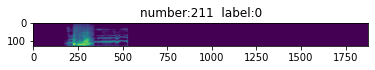

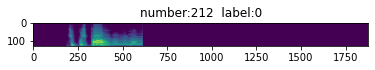

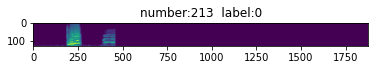

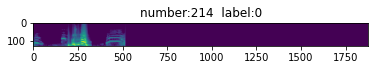

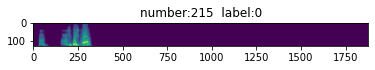

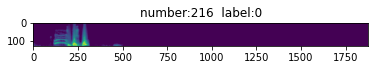

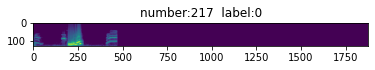

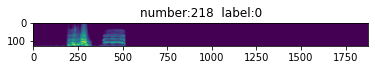

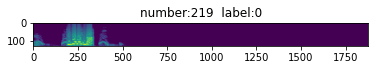

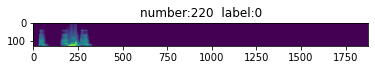

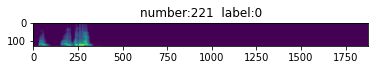

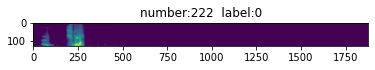

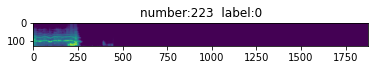

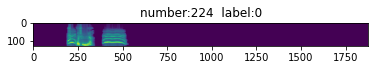

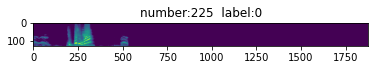

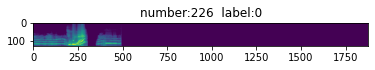

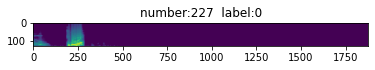

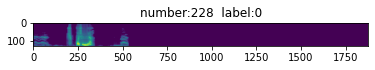

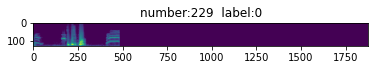

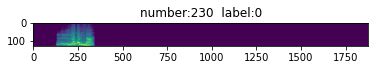

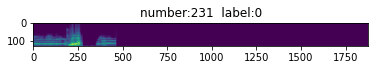

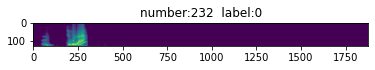

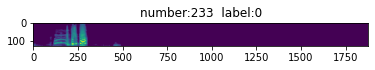

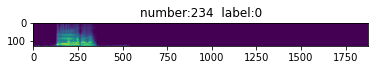

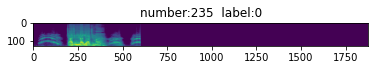

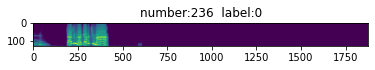

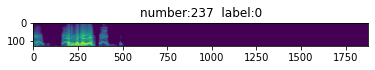

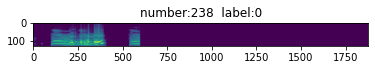

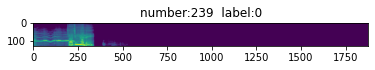

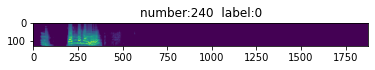

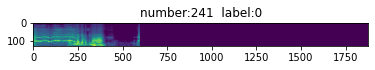

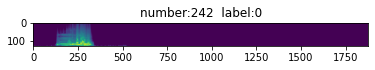

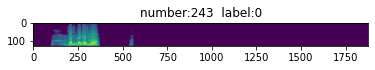

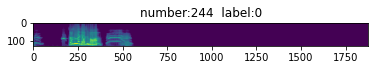

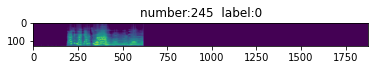

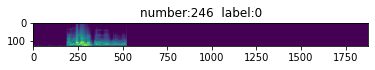

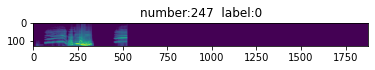

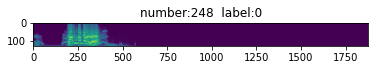

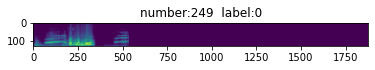

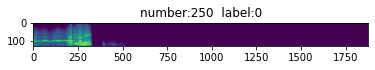

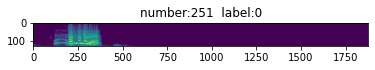

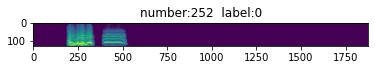

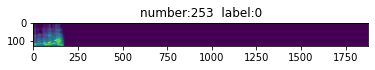

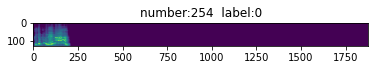

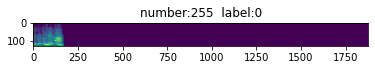

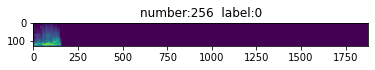

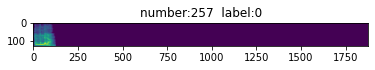

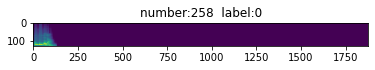

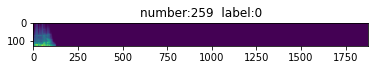

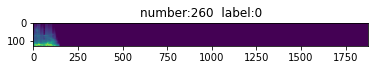

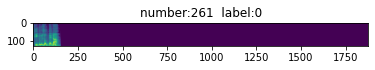

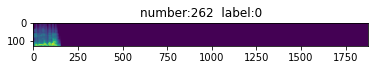

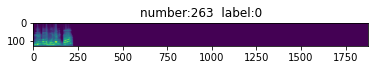

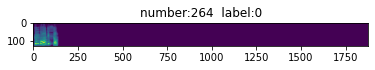

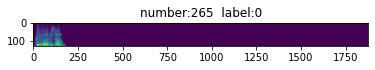

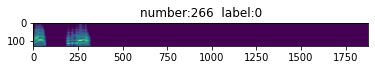

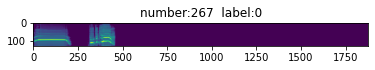

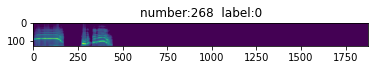

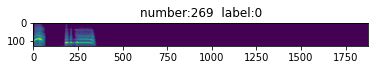

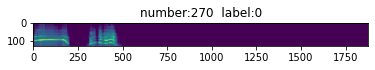

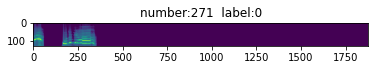

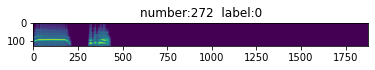

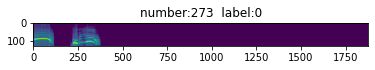

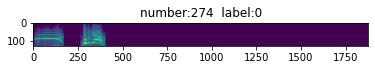

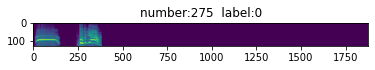

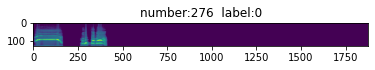

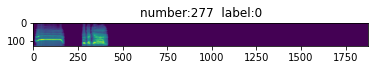

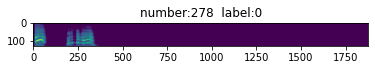

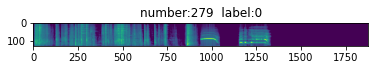

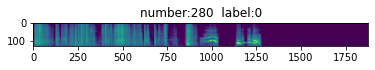

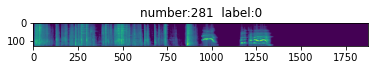

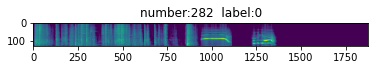

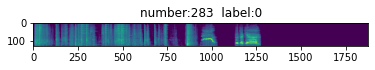

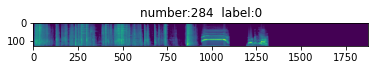

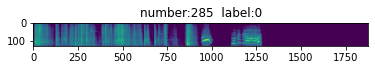

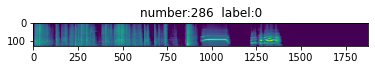

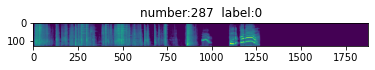

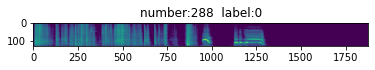

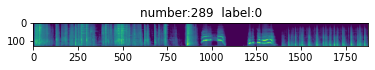

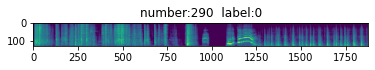

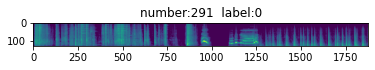

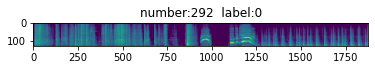

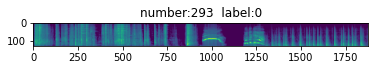

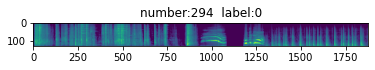

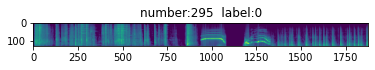

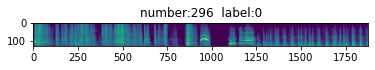

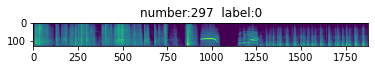

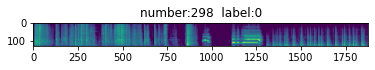

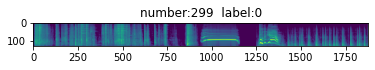

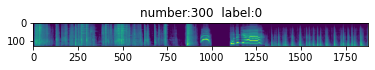

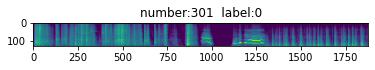

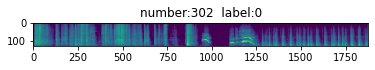

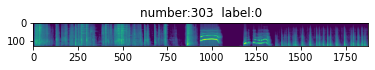

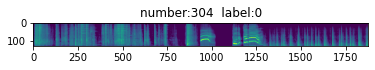

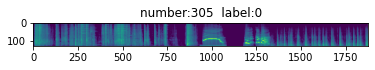

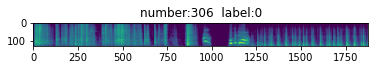

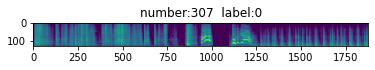

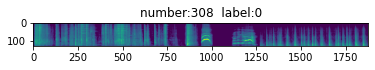

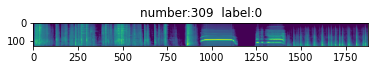

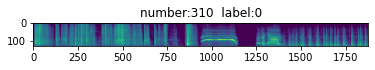

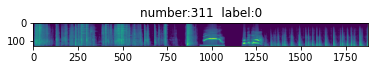

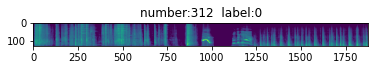

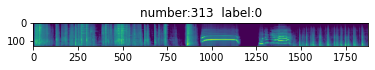

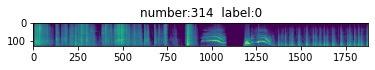

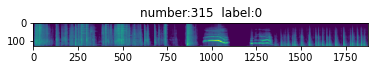

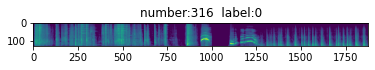

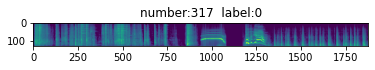

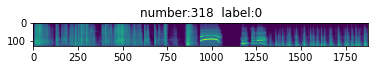

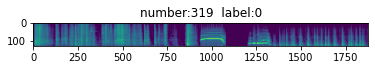

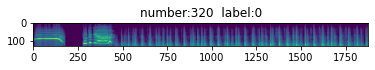

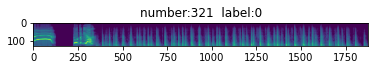

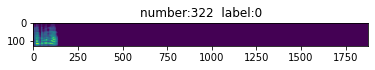

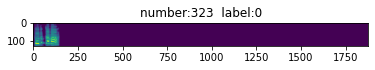

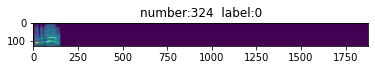

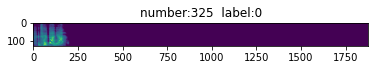

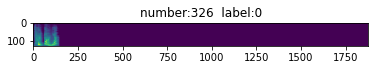

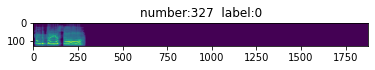

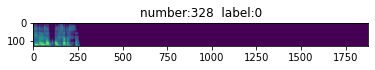

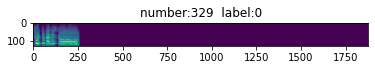

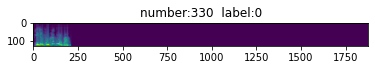

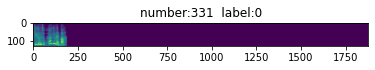

In [6]:
from matplotlib import pyplot as plt
for i in range(len(mel_images)):
    plt.figure()
    plt.title('number:%d  label:%d'%(i,mel_labels[i]))
    plt.imshow(mel_images[i])


In [7]:
from sklearn.preprocessing import StandardScaler
x_train = np.expand_dims(mel_images, 1) #DataNum, 1ch, H, W
scaler = StandardScaler()
x_train.shape
b,c,h,w = x_train.shape
x_train = np.reshape(x_train, newshape=(b,-1))
x_train = scaler.fit_transform(x_train)
x_train = np.reshape(x_train, newshape=(b,c,h,w))
x_tensor=torch.tensor(x_train,device=device).float()
print(x_tensor.shape)
print(type(x_tensor))

torch.Size([332, 1, 128, 1876])
<class 'torch.Tensor'>


In [8]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def normalize2(image):
    #image = (image - mean) / std
    #print(image)
    # in addition, roll the axis so that they suit pytorch
    return torch.tensor(image.swapaxes(-1, 1).swapaxes(2, 3)).float().to(device)

In [9]:
import torch
import torch.nn as nn

seed = 1
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

class ParallelModel(nn.Module):
    def __init__(self,num_emotions):
        super().__init__()

            # 1. conv block
        self.relu = nn.ReLU()
        self.conv1= nn.Conv2d(in_channels=1,
                   out_channels=16,
                   kernel_size=3,
                   stride=1,
                   padding=1
                  )
        
     
        self.bn1 = nn.BatchNorm2d(16)

        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.do = nn.Dropout2d(p=0.3)
        # 2. conv block
        self.conv2= nn.Conv2d(in_channels=16,
                   out_channels=32,
                   kernel_size=3,
                   stride=1,
                   padding=1
                  )
        self.bn2 = nn.BatchNorm2d(32)
        self.mp2 = nn.MaxPool2d(kernel_size=4, stride=4)

        # 3. conv block
        self.conv3 = nn.Conv2d(in_channels=32,
                   out_channels=64,
                   kernel_size=3,
                   stride=1,
                   padding=1
                  )
        self.bn3 = nn.BatchNorm2d(64)

        # 4. conv block
        self.conv4= nn.Conv2d(in_channels=64,
                   out_channels=128,
                   kernel_size=3,
                   stride=1,
                   padding=1
                  )
        self.bn4= nn.BatchNorm2d(128)

        # Linear softmax layer
        self.out_linear = nn.Linear(1792,num_emotions)
        #self.out_softmax = nn.Softmax(dim=1)
        
    def forward(self,x):

        # transformer embedding
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.do(self.mp1(out))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.do(self.mp2(out))
        out = self.relu(self.bn3(self.conv3(out)))
        out = self.do(self.mp2(out))
        out = self.relu(self.bn4(self.conv4(out)))
        out = self.do(self.mp2(out))


        conv_embedding = torch.flatten(out, start_dim=1)

        output_logits = self.out_linear(conv_embedding)
        #output_softmax = self.out_softmax(output_logits)
        return output_logits 
    
    
model = ParallelModel(num_emotions=2).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )


cuda
Number of trainable params:  101218


In [10]:
print(model)

ParallelModel(
  (relu): ReLU()
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (do): Dropout2d(p=0.3, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out_linear): Linear(in_features=1792, out_features=2, bias=True)
)


In [24]:
# load the model
#model = models.vgg16(pretrained=True).eval()
#model.to(device)
#model=nn.DataParallel(model)

#X2=x_tensor/255

example=[296,126] # 위험:0 / 일반상황: 1
to_explain2 = x_tensor[example]

print(to_explain2.shape)

e = shap.GradientExplainer(model, to_explain2)
shap_values2,indexes2 = e.shap_values(to_explain2, ranked_outputs=2, nsamples=200) #data에 적용된 모델의 값을 반환합니다.
print(indexes2)

# get the names for the classes
index_names2 = np.vectorize(lambda x: mel_labels[x])(example)
print(index_names2)

# plot the explanations
shap_values2 = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values2]


#shap.image_plot(shap_values2, to_explain2,plot_size=[50,50])

torch.Size([2, 1, 128, 1876])
tensor([[1, 0],
        [1, 0]], device='cuda:0')
[0 1]


In [25]:
type(x_train[example])

numpy.ndarray

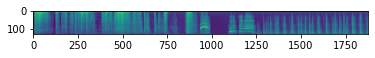

In [26]:
x_train[example]
plt.imshow(x_train[example][0][0])

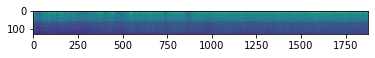

In [27]:
plt.imshow(x_train[example][1][0])

In [28]:
np.array(shap_values2).shape

(2, 2, 128, 1876, 1)

In [29]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING']="1"
# os.environ['CUDA_VISIBLE_DEVICES']="0"

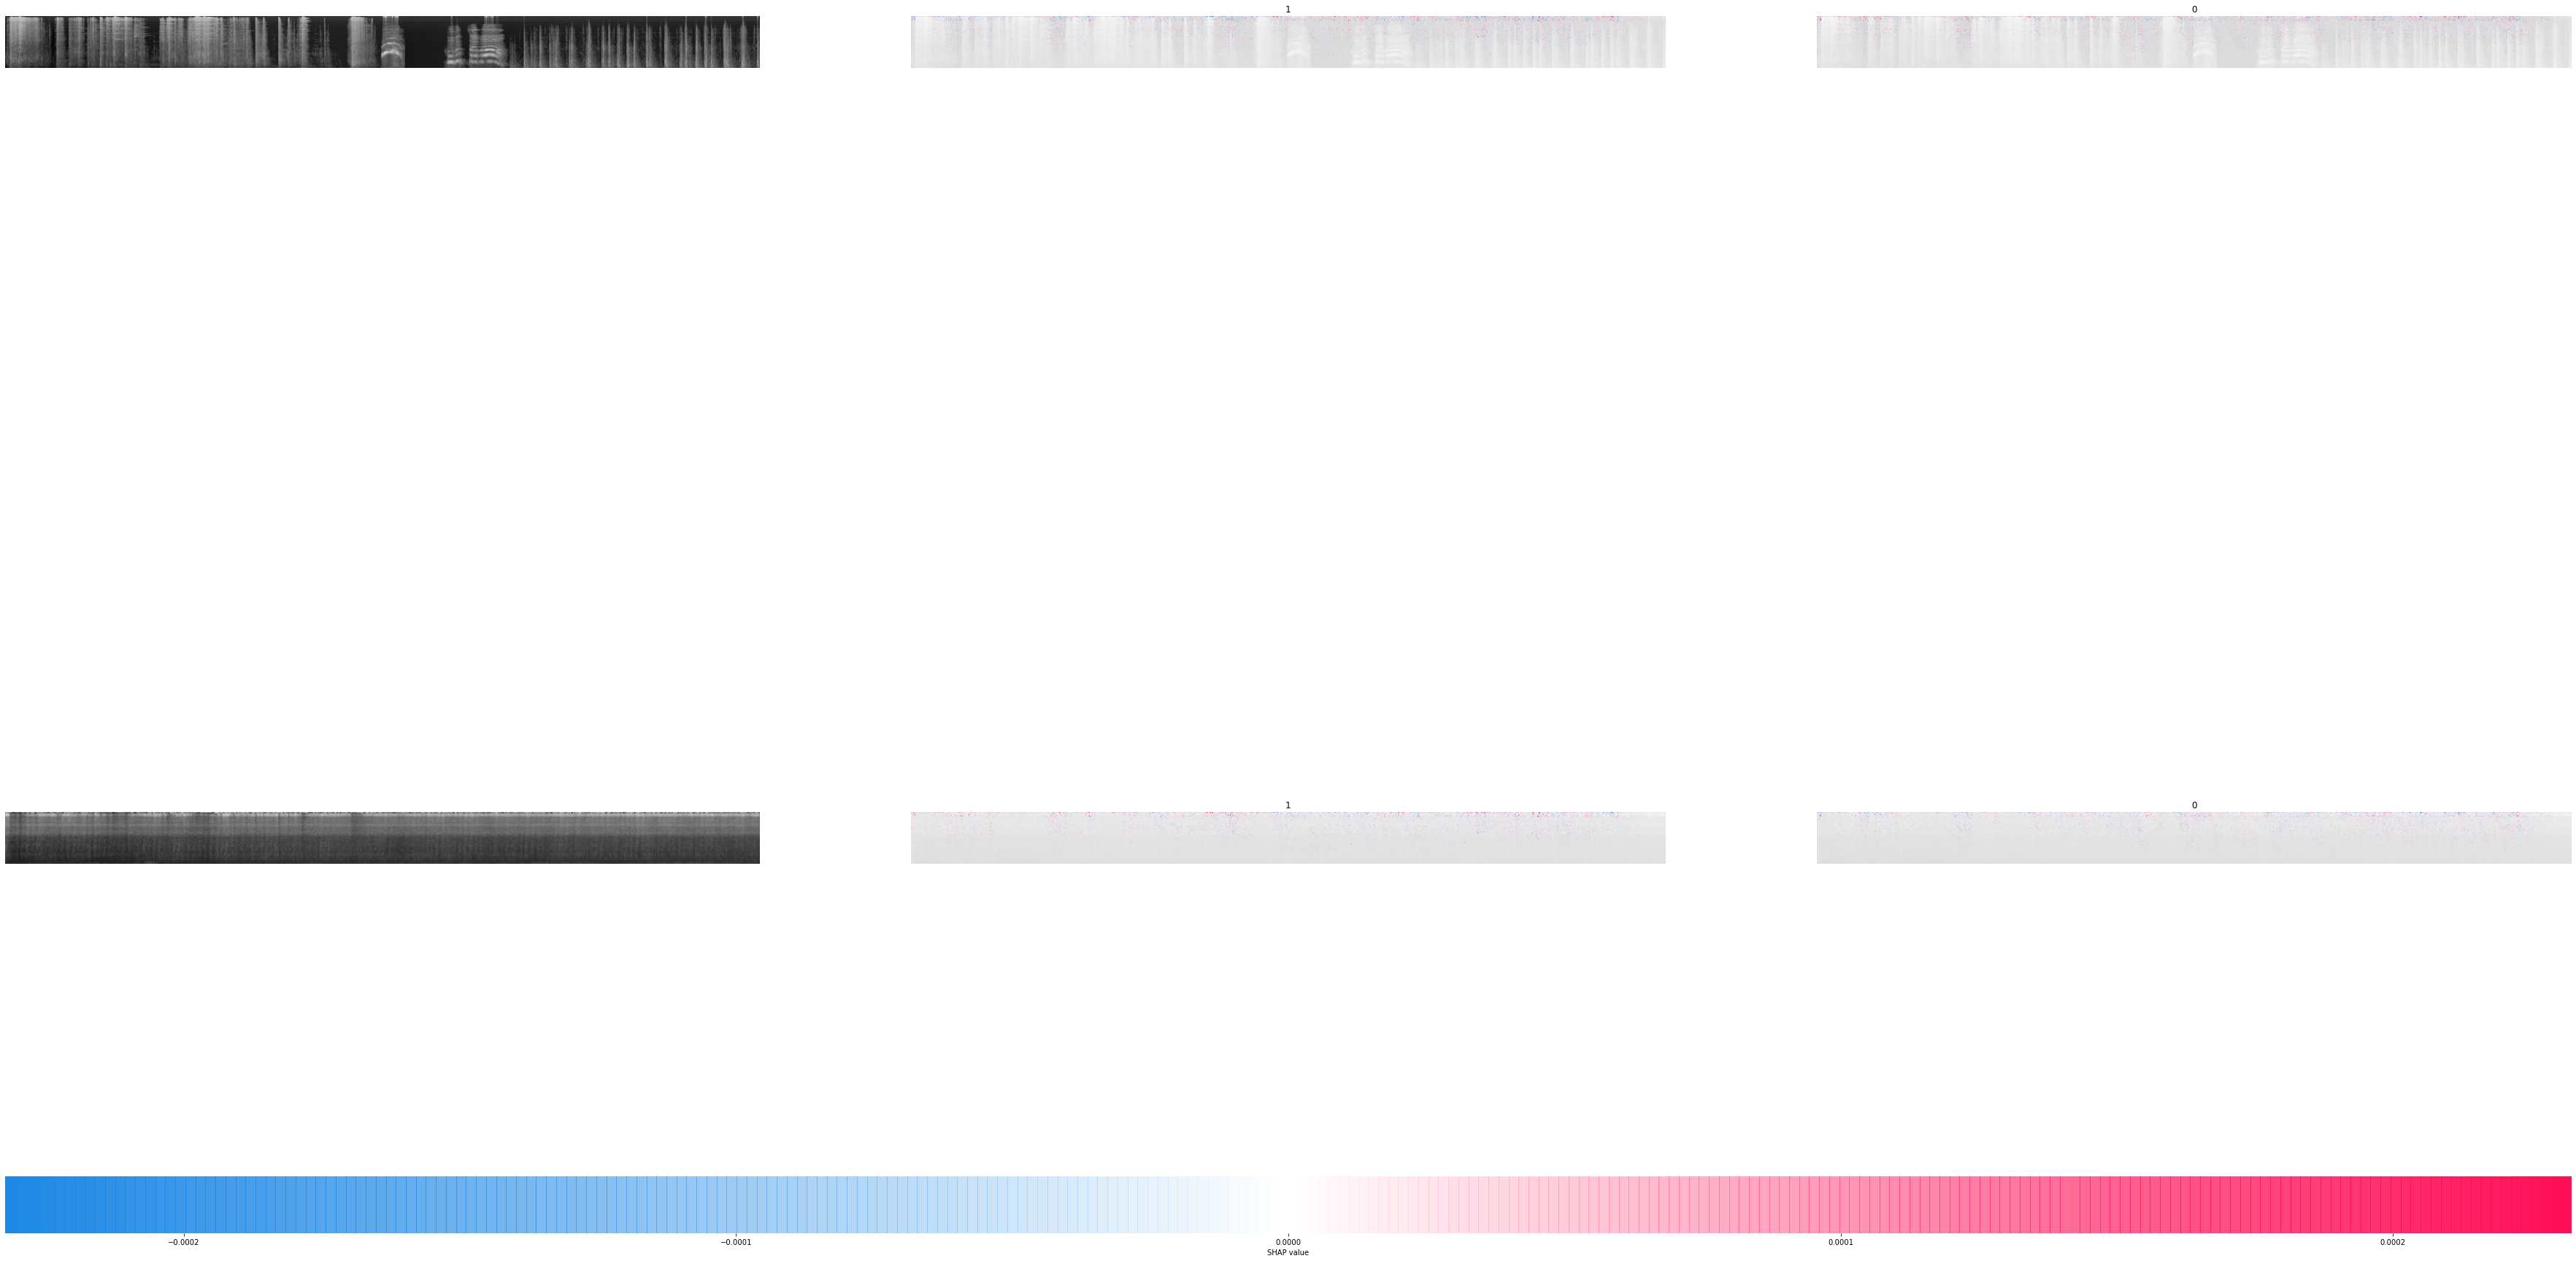

In [31]:
shap.image_plot(shap_values2, x_train[example].swapaxes(1,3).swapaxes(1,2),indexes2.cpu(),show=False)
w,h=plt.gcf().get_size_inches()
plt.gcf().set_size_inches(w*7,h*7)
plt.savefig('/home/vislab/dolearn-jimin-41/result_plt9.png')